# Building Agentic AI Chatbot Using LangGraph

Here we will build an agentic AI chatbot that can use multiple tools to answer user queries.

## Tools

We will use the following tools:

- `arxiv`: To search for papers on arxiv.
- `wikipedia`: To search for information on Wikipedia.
- `tavily`: To search for information on Tavily.

## LLM

we will use `qwen-qwq-32b` model from Groq.

## Imports

In [1]:
## tools

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
# Tavily search tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq

from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize the LLM Model
llm = ChatGroq(model="qwen-qwq-32b")

In [2]:
#arxiv tool
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [3]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [6]:
#wikipedia tool
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
# TAVILY TOOL
tavily = TavilySearchResults(api_key=os.getenv("TAVILY_API_KEY"))

In [8]:
tavily.invoke("What is the latest in AI news?")

[{'title': 'Artificial intelligence - NBC News',
  'url': 'https://www.nbcnews.com/artificial-intelligence',
  'content': "Profile\n\nSections\n\nLocal\n\ntv\n\nFeatured\n\nMore From NBC\n\nFollow NBC News\n\nnews Alerts\n\nThere are no new alerts at this time\n\nARTIFICIAL INTELLIGENCE\n\nThe latest news and top stories on artificial intelligence, including ChatGPT, AI Chatbot and Bard.\n\nChina's robots race against humans — and their U.S. counterparts\n\nViral AI-made art trends are making artists even more worried about their futures\n\nAI NEWS\n\nArtificial intelligence [...] NBC News NOW\n\n02:16\n\nVance says U.S. will be the ‘gold standard’ of AI technology\n\n03:36\n\nAI startup DeepSeek causes buzz in China but draws global scrutiny over censorship and security\n\nNBC News NOW\n\n02:03\n\nA.I. leaders say China may have copied U.S. technology\n\nNightly News\n\n08:23\n\nNew Chinese A.I. tool 'DeepSeek' competes with American models\n\nNBC News NOW\n\nMORE AI NEWS\n\nElon Musk

In [9]:
llm.invoke("What is AI and what model are you")

AIMessage(content="\n<think>\nOkay, so I need to explain what AI is and then describe my own model based on the user's question. Let me start by recalling what AI generally means. AI stands for Artificial Intelligence, right? It's when machines or computer systems are designed to perform tasks that typically require human intelligence. But I should be more specific. Maybe break it down into different types, like narrow or general AI. Narrow AI is like what we have now, doing specific tasks, and general AI is the hypothetical future kind that can do anything a human can.\n\nThen, the user also wants to know what model I am. Since I'm supposed to be Qwen, the answer should mention that. I should explain that I'm a large language model developed by Alibaba Cloud, created to understand and generate text across various topics. I need to detail the model's architecture, maybe mention that it's based on a transformer, which is a type of neural network. But how much technical detail should I i

## eqip the llm with tools



In [11]:
## combine all the tools in the list and bind to the llm

tools=[arxiv, wiki, tavily]

llm_with_tools = llm.bind_tools(tools=tools)

In [12]:
llm_with_tools.invoke("What is the latest research on consciousness?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b84x', 'function': {'arguments': '{"query": "consciousness"}', 'name': 'arxiv'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 469, 'prompt_tokens': 356, 'total_tokens': 825, 'completion_time': 1.141975655, 'prompt_time': 0.021643498, 'queue_time': 0.155476338, 'total_time': 1.163619153}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_512a3da6bb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7cf7d25d-7252-46e8-9c35-d49c5d114bb6-0', tool_calls=[{'name': 'arxiv', 'args': {'query': 'consciousness'}, 'id': 'call_b84x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 356, 'output_tokens': 469, 'total_tokens': 825})

## Workflow

Here we will define the nodes required for our chatbot. including the AI assistant, tools, and the state.


In [13]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ## Human message or AI message
from typing import Annotated # labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph


In [14]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] ## appending messages to the list


In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


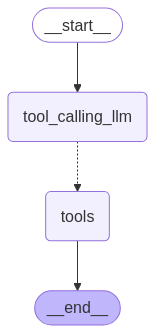

In [16]:
## Node definition

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) is a tool call --> tools_condition routes to tools
    # If the latest message (result) is not a tool call --> tools_condition routes to END
    tools_condition
    )
builder.add_edge("tools", END)

graph = builder.compile()

# View graph
display(Image(graph.get_graph().draw_mermaid_png()))




In [17]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_ss43)
 Call ID: call_ss43
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [18]:
messages=graph.invoke({"messages":"Hi Im Pouria"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi Im Pouria
================================== Ai Message ==================================

Hello Pouria! Nice to meet you. How can I assist you today?


In [19]:
messages=graph.invoke({"messages":"Can you tell me about world cup 2024"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Can you tell me about world cup 2024
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_2ryc)
 Call ID: call_2ryc
  Args:
    query: World Cup 2024 latest updates
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Women's T20 World Cup 2024 Latest News, Live Updates", "url": "https://sports.ndtv.com/women-s-t20-world-cup/news", "content": "New Zealand produced a clinical performance in a high-stakes final to beat South Africa by 32 runs and win their maiden Women's T20 World Cup title in Dubai on Sunday.\n\nSouth Africa vs New Zealand Highlights, Women's T20 World Cup 2024 Final: An outstanding all-round performance by Amelia Kerr led New Zealand to their first ever Women's T20 World Cup title. [...] South Africa Women vs New Zealand Women LIVE Telecast, 

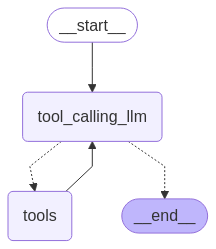

In [20]:
## Node definition

def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) is a tool call --> tools_condition routes to tools
    # If the latest message (result) is not a tool call --> tools_condition routes to END
    tools_condition,
    )
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

# View graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages=graph.invoke({"messages":"what is the recent AI news and please tell me the recent research paper on Quantum physics"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent AI news and please tell me the recent research paper on Quantum physics
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_6keq)
 Call ID: call_6keq
  Args:
    query: recent AI news
  arxiv (call_qcd4)
 Call ID: call_qcd4
  Args:
    query: quantum physics
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in March - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-march-2025/", "content": "The latest AI news we announced in March\n\nApr 04, 2025\n\n[[read-time]] min read\n\nHere’s a recap of some of our biggest AI updates from March, including Gemini 2.5 Pro, expanded access to AI Overviews, the release of AI Mode and more.\n\nGeneral summary [...] March was all about expanding 